In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import psql

In [2]:
def get_monthly_article_count(year, press_list, terms_01=[], terms_02=[], terms_03=[]):
    
    # 1. 단어목록이 있으면 필터 count
    if terms_01:
        # 리스트를 SQL 쿼리 형식으로 변환
        press_in = ",".join("'" + item + "'" for item in press_list)
        condition1 = " OR ".join("content LIKE '%%" + word + "%%'" for word in terms_01)  # psycopg2 에러 방지를 위해 %를 %%로 변경해둠
        condition2 = " OR ".join("content LIKE '%%" + word + "%%'" for word in terms_02)
        condition3 = " OR ".join("content LIKE '%%" + word + "%%'" for word in terms_03)

        # 쿼리 생성
        # query = f"""
        # SELECT SUBSTRING(date, 1, 6) as month, press, COUNT(*) as article_count
        # FROM data.news_{year}
        # WHERE press IN ({press_in})
        #   AND ({condition2})
        #   AND ({condition3})
        # GROUP BY month, press
        # ORDER BY month, press;
        # """
        query = f"""
        SELECT SUBSTRING(date, 1, 6) as month, press, COUNT(*) as article_count
        FROM data.news_{year}
        WHERE press IN ({press_in})
          AND ({condition1})
          AND ({condition2})
          AND ({condition3})
        GROUP BY month, press
        ORDER BY month, press;
        """
    
    # 2. 단어목록이 없으면 전체 count
    else:
        query = f"""
        SELECT SUBSTRING(date, 1, 6) as month, press, COUNT(*) as article_count
        FROM data.news_{year}
        GROUP BY month, press
        ORDER BY month, press;
        """
    
    # 쿼리 실행
    raw = psql.query_select(query)
    
    # 데이터프레임 변환
    df = pd.DataFrame(raw, columns=['month', 'press', 'article_count'])
    
    return df

### 실행

In [3]:
press_list = ['조선일보', '중앙일보', '동아일보', '경향신문', '한겨래']
# terms1 = ['불확실성', '불확실']
terms1 = ['확실', "위험", "명확"]  # "위험", "명확"  / 확실(불확실 포함)
terms2 = ['이산화탄소', '기후', '기후 위험', '온실', '온난화', '재생 에너지', "친환경 에너지", '환경']  # "온실"
terms3 = ['규제', '법률', '국회', '정책', "법", "정부"]
start_year = 2007
# start_year = 2020
end_year = 2024

In [4]:
 # 실행
dfs = []

tq = tqdm(range(start_year, end_year+1))
for year in tq:
    tq.set_description(f"year={year} ")
    
    df_filtered = get_monthly_article_count(year, press_list, terms1, terms2, terms3)
    df_all = get_monthly_article_count(year, press_list)

    df = pd.merge(df_filtered, df_all, on=['month', 'press'])
    df.rename(columns={'article_count_x': 'filtered', 'article_count_y': 'all'}, inplace=True)
    dfs.append(df)

df_monthly = pd.concat(dfs, axis=0)
df_monthly.reset_index(drop=True, inplace=True)
df_monthly.tail(25)

year=2024 : 100%|██████████| 18/18 [01:10<00:00,  3.94s/it]


,filtered,month,press,all
307,93,202310,중앙일보,5890
308,143,202311,경향신문,5903
309,88,202311,동아일보,5730
310,73,202311,조선일보,5364
311,115,202311,중앙일보,6149
312,123,202312,경향신문,5649
313,97,202312,동아일보,5446
314,76,202312,조선일보,5301
315,98,202312,중앙일보,5809
316,110,202401,경향신문,5674


In [5]:
df_monthly.groupby("month")[["filtered", "all"]].sum().tail(30)

,filtered,all
month,,
202111,455,24530
202112,432,25031
202201,411,22909
202202,358,21677
202203,384,24310
202204,341,23304
202205,413,23987
202206,402,23122
202207,379,23537


In [6]:
 # count 데이터 csv, xlsx 저장
df_monthly.to_csv('monthly_count.csv')
df_monthly.to_excel('monthly_count.xlsx')

In [7]:
# 인덱스 연산
df = df_monthly.copy()  # 연산할 데이터 가져옮

# 1. Scale: 관련 기사 수를 총 기사 수로 나눔
df['scaled'] = df['filtered'] / df['all']

# 2. Standardize: 각 신문사별로 표준화
df['standardized'] = df.groupby('press')['scaled'].transform(lambda x: (x - x.mean()) / x.std())

# 3. Average Across Each Month: 월별 평균 계산
monthly_avg = df.groupby('month')['standardized'].mean()

# 4. Normalize
# Min-Max 정규화를 적용하여 데이터를 0과 1 사이로 조정 (=최솟값이 0이 됨)
normalized = (monthly_avg - monthly_avg.min()) / (monthly_avg.max() - monthly_avg.min())

# 평균이 100이 되도록 스케일링
normalized = normalized * (100 / normalized.mean())

# # 최소값이 0이 되도록 조정
# normalized = normalized - normalized.min()

# 결과 출력
normalized

month
201601           0.0
201602     30.821123
201603     20.052007
201604     31.003203
201605     49.483367
             ...    
202312    134.098027
202401    107.969325
202402    120.766015
202403     105.46212
202404    120.252113
Name: standardized, Length: 100, dtype: object

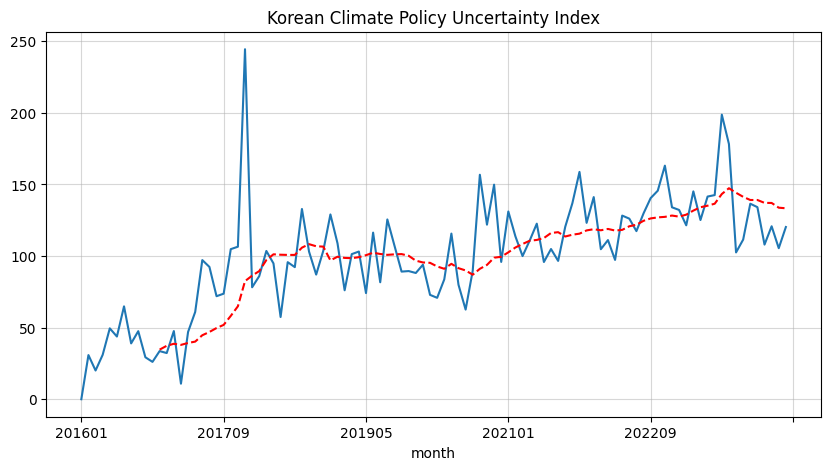

In [11]:
normalized.plot(figsize=(10, 5))
normalized.rolling(12).mean().plot(color="red", linestyle='--')  # 12개월 이동평균
plt.grid(alpha=0.5)
plt.title('Korean Climate Policy Uncertainty Index')
plt.savefig('index_cpu_draft.png')
plt.show()

In [9]:
# 인덱스 저장 (csv, xslx)
normalized.to_csv('index_cpu.csv')
normalized.to_excel('index_cpu.xlsx')

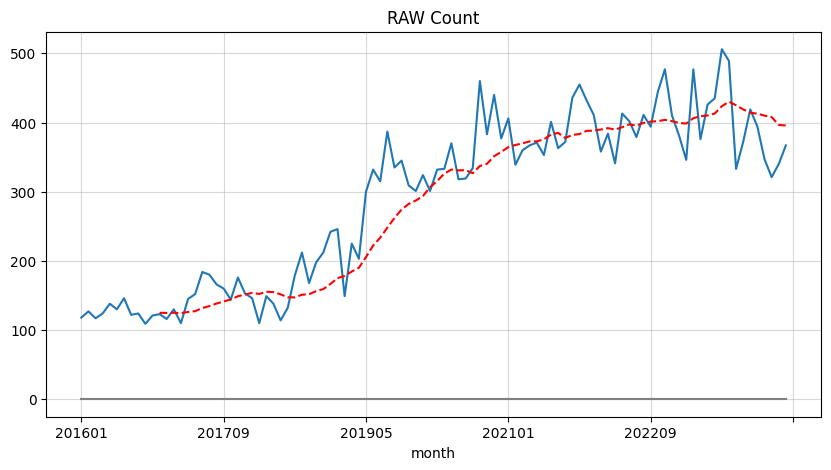

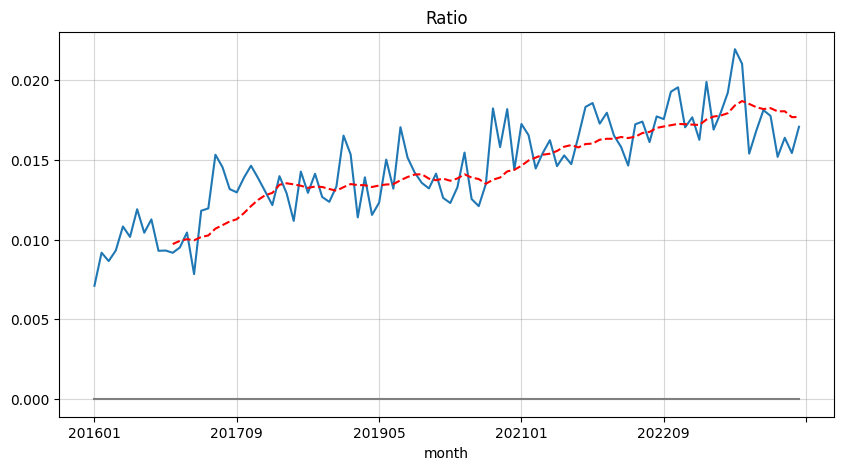

In [10]:
# 데이터 개수들 plot 
grp_sum = df_monthly.groupby('month')['filtered'].sum()
grp_sum_all = df_monthly.groupby('month')['all'].sum()

# filtered raw count
grp_sum.plot(title='RAW Count', figsize=(10, 5))
plt.plot(grp_sum.index, [0] * len(grp_sum.index), color='gray')
grp_sum.rolling(12).mean().plot(color="red", linestyle='--')
plt.grid(alpha=0.5)
plt.savefig('data_count.png')
plt.show()

# filtered/all ratio
plot_data = (grp_sum / grp_sum_all)
plot_data.plot(title="Ratio", figsize=(10, 5))
plt.plot(grp_sum.index, [0] * len(grp_sum.index), color='gray')
plot_data.rolling(12).mean().plot(color="red", linestyle='--')
plt.grid(alpha=0.5)
plt.savefig('data_ratio.png')
plt.show()